<a href="https://colab.research.google.com/github/ziatdinovmax/gpax/blob/main/examples/gpax_UIGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian process with uncertain inputs

*Prepared by Maxim Ziatdinov (January 2024)*



In many experimental and real-world settings, the exact values of input parameters are often subject to variability. This could be due to measurement errors, fluctuations in environmental conditions, or inherent variability in the system being studied. Ignoring this uncertainty can lead to overconfident and potentially misleading predictions. By acknowledging and modeling this uncertainty directly, we can make more robust and reliable predictions.

To address this, GPax offers a UIGP model (UI stands for the Uncertainty in Inputs). The UIGP augments ExactGP by drawing inputs from a normal distribution centered around the parameter value $X$, with a learnable standard deviation of $\sigma_x$,

$$\sigma_x\sim HalfNormal(s) $$
$$X'\sim Normal(X, \sigma_x) $$

where $s$ is defined by a user. GPax uses a default value of $0.1$ since we assume that $X$ is normalized to $(0, 1)$. You may want to adjust it if your data range is very different.

The rest of the model is just a standard GP, which now operates on $X'$ instead of $X$:

$$f \sim MultivariateNormal(0; K(x'_i, x'_j))$$
$$y = f(X') + \epsilon$$

where $\epsilon$ is normally-distributed noise with a learnable variance.

At the prediction stage, we replace $X$ and $X_*$ with samples from distributions around those input values, $X'$ and $X'_*$, where $X'_* \sim Normal(X_*, \sigma^{post}_x)$.

Install GPax:

In [1]:
!pip install -q git+https://github.com/ziatdinovmax/gpax

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.0/371.0 kB 18.8 MB/s eta 0:00:00


Imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import gpax

gpax.utils.enable_x64()  # enable double precision

Generate data with randomly shifted input values:

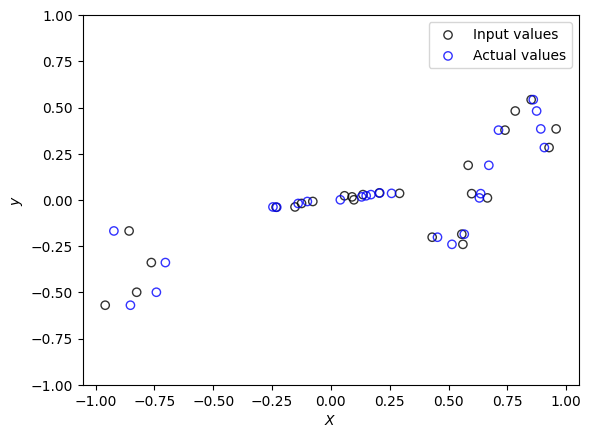

In [3]:
NUM_INIT_POINTS = 25 # number of observation points


np.random.seed(0)

# Generate data with randomly shifted inputs
def f(x, var_x=0.06):
    x_shifted = np.random.normal(x, var_x)
    return x_shifted, np.sin(10*x_shifted) * x_shifted**2

X = np.random.uniform(-1., 1., NUM_INIT_POINTS)

X_shifted, y = f(X)

X_test = np.linspace(-1.1, 1.1, 200)

# Plot generated data
plt.figure(dpi=100)
plt.xlabel("$X$")
plt.ylabel("$y$")
plt.scatter(X, y, marker='o', facecolors='none', edgecolors='k', zorder=2, label="Input values", alpha=0.8)
plt.scatter(X_shifted, y, marker='o', facecolors='none', edgecolors='b', zorder=2, label="Actual values", alpha=0.8)
plt.legend()
plt.ylim(-1, 1);

Next, we set the GP priors. While this step is optional and you could proceed with the default settings, it is advisable to define your priors if you have even a basic understanding of your data. For instance, we know the lower and upper bounds for $X$ since we are the ones defining the parameter space where we operate. If a kernel's lengthscale exceeds half the parameter space's size, it's likely to be less informative. Therefore, we select the prior for the kernel lengthscale to reflect this.

Additionaly, we assume that our measurements are characterized by low noise (not to be confused with uncertainty in inputs) and define the prior over the noise variance as a half-normal distribution with a standard deviation of $0.1$.

It's also possible to specify a prior over the input distribution. In this case, we will stick with the default option, which is a Half-Normal distribution with a standard deviation of $0.1$.

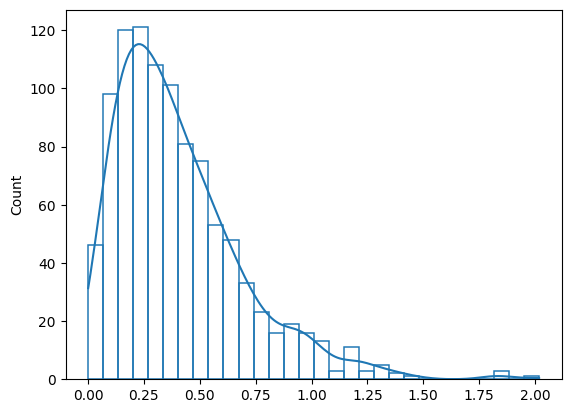

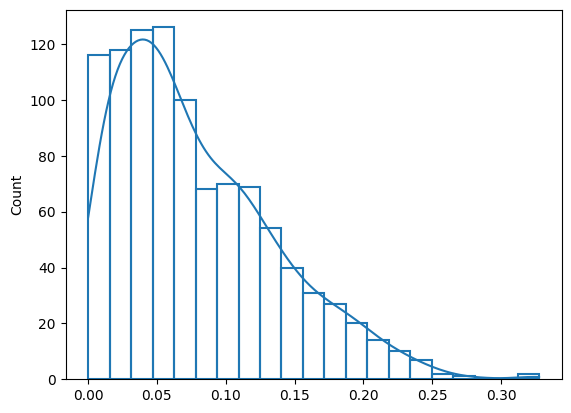

In [4]:
lengthscale_prior = gpax.utils.gamma_dist(2, 5)
noise_prior = gpax.utils.halfnormal_dist(0.1)

gpax.utils.dviz(lengthscale_prior)
gpax.utils.dviz(noise_prior)

## Standard GP

First, we run a standard GP

In [5]:
key1, key2 = gpax.utils.get_keys()

# initialize model
model = gpax.ExactGP(1, 'Matern',
                     lengthscale_prior_dist=lengthscale_prior,
                     noise_prior_dist=noise_prior)

# train
model.fit(key1, X, y, num_warmup=5000, num_samples=5000)

sample: 100%|██████████| 10000/10000 [00:12<00:00, 800.10it/s, 3 steps of size 5.74e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.49      0.20      0.45      0.20      0.80   3120.02      1.00
    k_scale      0.38      0.42      0.26      0.04      0.78   2748.90      1.00
      noise      0.02      0.01      0.02      0.01      0.03   2666.26      1.00



Make a prediction for the full parameter space:

In [6]:
y_pred, y_sampled = model.predict(key2, X_test, noiseless=True)

Plot results:

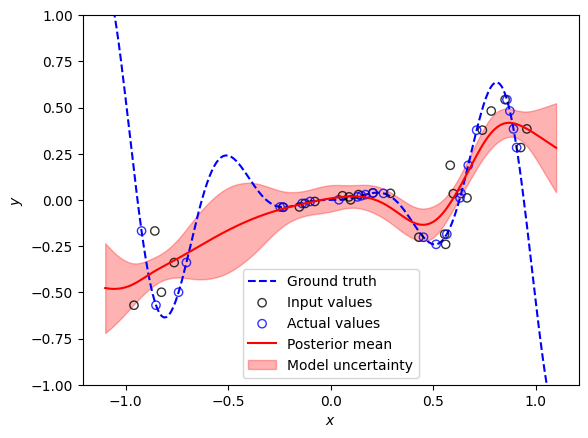

In [7]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

ax.plot(X_test, np.sin(10*X_test) * X_test**2, '--', c='b', label="Ground truth")

ax.scatter(X, y, marker='o', facecolors='none', edgecolors='k', zorder=2, label="Input values", alpha=0.8)
ax.scatter(X_shifted, y, marker='o', facecolors='none', edgecolors='b', zorder=2, label="Actual values", alpha=0.8)

ax.plot(X_test, y_pred, lw=1.5, zorder=2, c='r', label='Posterior mean')
ax.fill_between(X_test, y_pred - y_sampled.std(axis=(0,1)), y_pred + y_sampled.std(axis=(0,1)),
                color='r', alpha=0.3, label="Model uncertainty")
ax.legend(loc='best')
ax.set_ylim(-1.0, 1.0);

We can see that the standard GP underestimates the uncertainty in multiple regions. An underestimation of uncertainty could lead to overconfidence in model predictions and potentially poor decision-making. For example, since GP uncertainty is commonly used in active learning and Bayesian optimization, this could make these methods less efficient, as they rely on accurate uncertainty estimates to make decisions about where to sample next or how to navigate the search space.

Let's see if UIGP can address this issue.

## GP for Uncertain Inputs

Initialize and train UIGP model:

In [8]:
key1, key2 = gpax.utils.get_keys()

model = gpax.UIGP(1, 'Matern',
                  lengthscale_prior_dist=lengthscale_prior,
                  noise_prior_dist=noise_prior)

model.fit(key1, X, y, num_warmup=5000, num_samples=5000)

/usr/local/lib/python3.10/dist-packages/gpax/models/uigp.py:171: UserWarning: The default `sigma_x` prior for uncertain (stochastic) inputs assumes data is normalized to (0, 1), which is not the case for your data. Therefore, the default prior may not be optimal for your case. Consider passing custom prior for sigma_x, for example, `sigma_x_prior_dist=numpyro.distributions.HalfNormal(scale)` if using NumPyro directly or `sigma_x_prior_dist=gpax.utils.halfnormal_dist(scale)` if using a GPax wrapper
  warnings.warn(
sample: 100%|██████████| 10000/10000 [00:43<00:00, 229.66it/s, 31 steps of size 5.90e-02. acc. prob=0.84]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.39      0.13      0.37      0.20      0.59    144.31      1.02
    k_scale      0.41      0.40      0.28      0.04      0.81   1744.33      1.00
      noise      0.00      0.00      0.00      0.00      0.00    822.51      1.00
    sigma_x      0.08      0.03      0.08      0.04      0.12    133.29      1.02



Make a prediction for the full parameter space:

In [9]:
y_pred, y_sampled = model.predict(key2, X_test, noiseless=True)

Plot results:

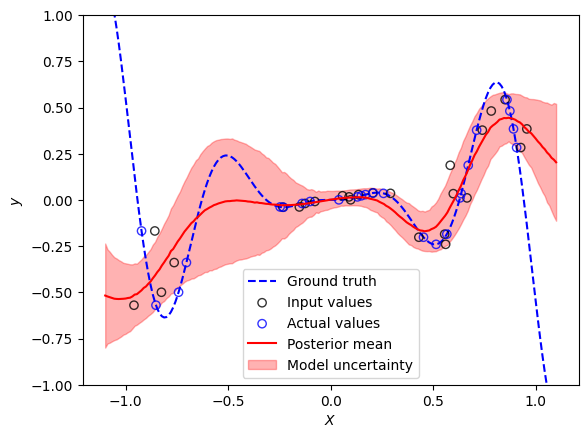

In [10]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$X$")
ax.set_ylabel("$y$")

ax.plot(X_test, f(X_test, 0)[1], '--', c='b', label="Ground truth")

ax.scatter(X, y, marker='o', facecolors='none', edgecolors='k', zorder=2, label="Input values", alpha=0.8)
ax.scatter(X_shifted, y, marker='o', facecolors='none', edgecolors='b', zorder=2, label="Actual values", alpha=0.8)

ax.plot(X_test, y_pred, lw=1.5, zorder=2, c='r', label='Posterior mean')

ax.fill_between(X_test, y_pred - y_sampled.std(axis=(0,1)), y_pred + y_sampled.std(axis=(0,1)),
                color='r', alpha=0.3, label="Model uncertainty")
ax.legend(loc='best')
ax.set_ylim(-1.0, 1.0);

We can see that accounting for the uncertainty in inputs leads to an improvement in the uncertainty estimation as well as in the overall prediction.